# Introduction

This notebook evaluates multiple statistical anomaly detection methods on the machine_temperature_system_failure.csv dataset from the Numenta Anomaly Benchmark (NAB). We use labeled anomaly windows to compute precision, recall, and F1 score for each method using NAB-style scoring.
The statistical methods are fast, interpretable, and serve as strong baselines before applying machine learning or deep learning models.

## Imports and load data

In [400]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.metrics import precision_score, recall_score, f1_score

In [401]:
# load data
url = "https://raw.githubusercontent.com/hjalalin/nab-anomaly-detection/main/data/realKnownCause/machine_temperature_system_failure.csv"
df = pd.read_csv(url)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [402]:
# Load labeled Anomaly Windows
url = "https://raw.githubusercontent.com/hjalalin/nab-anomaly-detection/main/data/labels/combined_windows.json"
response = requests.get(url)
labels = response.json()

anomaly_windows = [
    (pd.to_datetime(start), pd.to_datetime(end))
    for start, end in labels["realKnownCause/machine_temperature_system_failure.csv"]
]

## Scoring Fucntion
We evaluate each detection method by checking if its predicted anomalies fall within known anomaly windows. If a detection lands inside a window, it's counted as a true positive. This allows us to compute:

Precision = TP / (TP + FP) → How many detected anomalies were actually correct

Recall = TP / (TP + FN) → How many actual anomalies were successfully detected

F1 Score = 2 × (Precision × Recall) / (Precision + Recall) → Balances both metrics when both false positives and false negatives matter

In [403]:
def score_with_windows(detected_times, windows, full_index):
    # Build binary ground truth vector
    y_true = pd.Series(False, index=full_index)
    for start, end in windows:
        y_true[(full_index >= start) & (full_index <= end)] = True

    # Build binary prediction vector
    y_pred = pd.Series(full_index.isin(detected_times), index=full_index)

    # Calculate metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {"precision": precision, "recall": recall, "f1": f1}


## Anomaly Detection Methods
This section implements and describes six statistical methods for identifying anomalies in a univariate time series. Each method captures a different type of abnormal behavior — from sudden spikes and drops to gradual shifts in operating patterns.

Here’s a high-level comparison of the statistical techniques applied:
window tuning; can lag during rapid changes           |
| Method                | Type       | Description                                                              | Best For                   | Strengths                                            | Limitations                                               |
|-----------------------|------------|---------------------------------------------------------------------------|----------------------------|-------------------------------------------------------|------------------------------------------------------------|
| **Z-Score**           | Global     | Detects anomalies based on values that fall beyond ±k standard deviations | Spikes and dips            | Simple, fast, and interpretable                      | Ignores time structure; sensitive to outliers and skew     |
| **Rolling Mean ± k×σ**| Local      | Compares each point to a rolling mean ± k×rolling std over a sliding window | Context-aware anomalies    | Adapts to local behavior; good for short-term shifts | Needs window tuning; can lag during rapid changes          |
| **IQR**               | Global     | Identifies values outside Q1 − k×IQR or Q3 + k×IQR                         | Stable signal outliers     | Robust to outliers and non-normal distributions      | Ignores local trends and temporal dependencies             |
| **MAD**               | Global     | Detects outliers based on deviation from median using k×MAD               | Skewed or noisy data       | Effective with skewed and noisy data                 | Not sensitive to subtle changes or local drifts            |
| **Percent Change**    | Pointwise  | Flags points with relative change above a set percentage threshold        | Sudden jumps or drops      | Good for detecting sudden spikes or drops            | Ignores trend or seasonality; sensitive to noise           |
| **CUSUM**| Sequential | Accumulates deviations from mean; flags if sum exceeds a threshold        | Sustained shifts or drifts | Good for detecting slow changes and regime shifts    | Sensitive to noise; requires smoothing and tuning          |





### Z-score
Detects anomalies by checking if a value falls beyond ±3 standard deviations from the overall mean. Best for sudden spikes or dips in normally distributed signals.

In [404]:
def detect_zscore(df, column='value', threshold=3):
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    anomalies = df[z_scores.abs() > threshold].index
    return anomalies

 ### Rolling Mean ± k×std
 Flags anomalies when a value deviates from the local rolling mean by more than a multiple of the local rolling standard deviation. Useful for detecting context-aware outliers in non-stationary signals.


In [405]:
def detect_rolling_mean(df, column='value', window_size=30, threshold=3):
    rolling_mean = df[column].rolling(window=window_size, min_periods=1).mean()
    rolling_std = df[column].rolling(window=window_size, min_periods=1).std()
    residual = df[column] - rolling_mean

    # Fill NaNs in rolling std to avoid warning
    rolling_std = rolling_std.fillna(0)

    mask = residual.abs() > threshold * rolling_std
    anomalies = df[mask].index
    return anomalies


### Interquartile Range (IQR)
Flags values outside the typical range by using the 25th and 75th percentiles.

In [406]:
def detect_iqr(df, column='value', k=1.5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    anomalies = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
    return anomalies


### Median Absolute Deviation (MAD)
Identifies outliers based on how far each value is from the median. A robust method that works well on skewed or noisy data.


In [407]:
def detect_mad(df, column='value', threshold=3.5):
    median = df[column].median()
    mad = (np.abs(df[column] - median)).median()
    if mad == 0:
        return df.index[[]]  # avoid divide-by-zero
    modified_z = 0.6745 * (df[column] - median) / mad # 0.6745 scales MAD to match standard deviation for normal distribution
    anomalies = df[np.abs(modified_z) > threshold].index
    return anomalies


### Percent change
Flags values that show a sudden relative jump or drop compared to the previous point. Useful for identifying sharp level shifts in time series.

In [408]:
def detect_percent_change(df, column='value', change_pct=0.05):
    pct_change = df[column].pct_change().abs()
    pct_change = pct_change.fillna(0)  # avoid NaNs from first row
    anomalies = df[pct_change > change_pct].index
    return anomalies

 ### CUSUM (Cumulative Sum)
 Detects gradual shifts by tracking accumulated deviations from the mean. An anomaly is flagged when the cumulative sum exceeds a set threshold.

In [409]:
def detect_cusum(df, column='value', threshold_factor=3.5, drift_factor=0.2, smooth_window=30):
    if smooth_window:
        values = df[column].rolling(window=smooth_window, min_periods=1).mean().values
    else:
        values = df[column].values

    mean_val = values.mean()
    std_val = values.std()
    
    threshold = threshold_factor * std_val
    drift = drift_factor * std_val

    s_pos, s_neg = 0, 0
    anomalies = []

    for i, x in enumerate(values):
        s_pos = max(0, s_pos + x - mean_val - drift)
        s_neg = min(0, s_neg + x - mean_val + drift)

        if s_pos > threshold or s_neg < -threshold:
            anomalies.append(df.index[i])
            s_pos, s_neg = 0, 0  # reset after detection

    return pd.to_datetime(anomalies)


## Run and Score All Methods

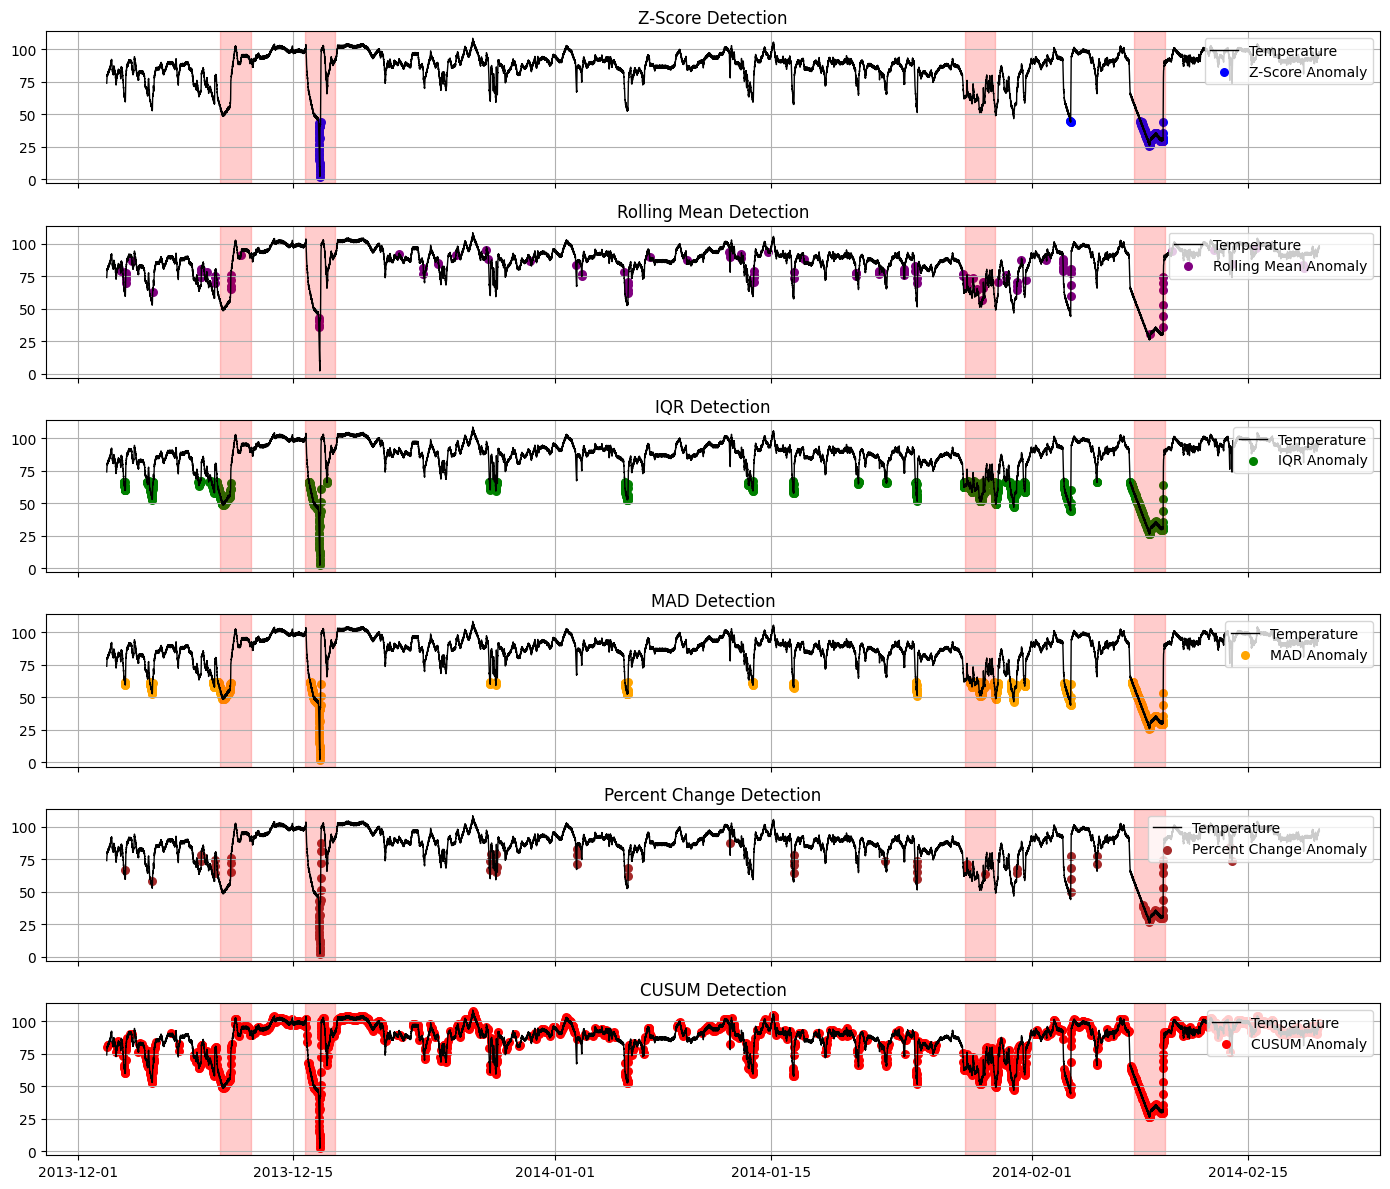

In [410]:
methods = [
    ('Z-Score', 'anomaly_zscore', 'blue'),
    ('Rolling Mean', 'anomaly_rolling', 'purple'),
    ('IQR', 'anomaly_iqr', 'green'),
    ('MAD', 'anomaly_mad', 'orange'),
    ('Percent Change', 'anomaly_pctchange', 'brown'),
    ('CUSUM', 'anomaly_cusum', 'red')
]

# Run detectors and create boolean columns
df['anomaly_zscore'] = df.index.isin(detect_zscore(df))
df['anomaly_rolling'] = df.index.isin(detect_rolling_mean(df))
df['anomaly_iqr'] = df.index.isin(detect_iqr(df))
df['anomaly_mad'] = df.index.isin(detect_mad(df))
df['anomaly_pctchange'] = df.index.isin(detect_percent_change(df))
df['anomaly_cusum'] = df.index.isin(detect_cusum(df))



fig, axes = plt.subplots(len(methods), 1, figsize=(14, 12), sharex=True)

for i, (title, col, color) in enumerate(methods):
    ax = axes[i]
    ax.plot(df['value'], label='Temperature', color='black', linewidth=1)
    ax.scatter(df[df[col]].index, df[df[col]]['value'], color=color, s=30, label=f'{title} Anomaly')

    # Highlight anomaly windows
    for start, end in anomaly_windows:
        ax.axvspan(start, end, color='red', alpha=0.2)
   
    ax.set_title(f"{title} Detection")
    ax.legend(loc='upper right')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [411]:
scoring_results = []

for name, col, _ in methods:
    detected_times = df[df[col]].index
    score = score_with_windows(detected_times, anomaly_windows, df.index)
    score['method'] = name
    scoring_results.append(score)

score_df = pd.DataFrame(scoring_results).set_index('method')
score_df[['precision', 'recall', 'f1']].sort_values('f1', ascending=False)


,precision,recall,f1
method,,,
IQR,0.580070,0.587743,0.583881
MAD,0.644165,0.496473,0.560757
CUSUM,0.315808,0.405203,0.354963
Z-Score,0.991342,0.201940,0.335531
Percent Change,0.680328,0.036596,0.069456
Rolling Mean,0.224138,0.011464,0.021812


### Performance Summary
**IQR** and **MAD** achieved the most reliable results, offering a strong balance between precision and recall. Their robustness to noise and sensitivity to sharp deviations make them well-suited for this dataset, where anomalies tend to appear as sudden spikes rather than gradual drifts.

**Z-Score** achieved very high precision but suffered from low recall, meaning it only flagged the most extreme anomalies and missed subtler ones. Lowering the threshold could improve sensitivity, though it may reduce precision.

**CUSUM** produced many false positives, resulting in low precision. This method is designed for detecting sustained shifts, it does not perform well in noisy environments and often misses sudden spikes.

**Percent Change** showed moderate precision but low recall, suggesting it failed to detect many actual anomalies. Reducing the percentage threshold could improve coverage but risks increasing false alarms. 

**Rolling Mean** performed the weakest overall. The selected window size and threshold likely didn’t align with the anomaly patterns in the data, causing poor detection. This method may benefit from refined parameters or from being used in combination with other techniques.

Overall, **IQR** and **MAD** are the most reliable methods in this setting. They require minimal tuning, handle noise effectively, and are particularly good at identifying isolated outliers in relativelty stable signals.